In [1]:
!pip install -q numpy pandas matplotlib tensorflow


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# =========================
# Cell 1: Setup & Imports
# =========================
import os
import random
import time
from collections import deque


import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Input, TimeDistributed, Conv1D, MaxPool1D,
LSTM, Dense, Flatten, Concatenate)

In [2]:
# ----------------------
# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


# Limit TF logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# Configure GPU growth if GPUs present
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)
for g in physical_gpus:
    try:
        print("GPU present")
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        print("GPU not present")
        pass


print("Python, NumPy and TensorFlow ready. TF version:", tf.__version__)


# =========================

[]
Python, NumPy and TensorFlow ready. TF version: 2.20.0


In [3]:
# =========================
# Cell 2: Configuration Constants
# =========================
# Environment
N_NODES = 5
N_METRICS = 5 # [CPU, Mem, BW, Queue, Power]
N_HISTORY = 3


# RL / DQN hyperparams
GAMMA = 0.99
LEARNING_RATE = 1e-3
REPLAY_MEMORY_SIZE = 20000
MIN_REPLAY_MEMORY_SIZE = 500
MINIBATCH_SIZE = 32
UPDATE_TARGET_MODEL_EVERY = 5 # episodes


EPSILON = 1.0
EPSILON_DECAY = 0.995
MIN_EPSILON = 0.01


EPISODES = 200
STEPS_PER_EPISODE = 200


# Simulation constants
TASK_SIZE_MI = 100
NODE_MIPS_CAPACITY = 500
BASE_COST_PER_STEP = 0.1
ENERGY_RATE_PER_UTIL = 0.05


# File paths
MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)


# Misc
DEBUG = False
PRINT_EVERY = 2

In [4]:
# =========================
# Cell 3: Environment Implementation (iFogSimEnv)
# =========================
class iFogSimEnv:
    """
    Synthetic environment that mimics multi-node (edge/cloud) resource metrics.
    State shape: (n_history, n_nodes, n_metrics)
    """
    def __init__(self, n_nodes=N_NODES, n_metrics=N_METRICS, n_history=N_HISTORY):
        self.n_nodes = n_nodes
        self.n_metrics = n_metrics
        self.n_history = n_history
        self.action_space_size = n_nodes
        self.state_shape = (n_history, n_nodes, n_metrics)

        self.history = deque([self._generate_random_snapshot() for _ in range(n_history)], maxlen=n_history)
        self.current_step = 0

        self.MIPS_capacity = np.ones(n_nodes) * NODE_MIPS_CAPACITY
        self.base_cost = BASE_COST_PER_STEP

    def reset(self):
        self.history = deque([self._generate_random_snapshot() for _ in range(self.n_history)], maxlen=self.n_history)
        self.current_step = 0
        return self._get_current_state()

    def _generate_random_snapshot(self):
        # Metrics: [CPU_Util, Mem_Util, BW_Util, Queue_Len (norm), Power_Cons]
        snapshot = np.zeros((self.n_nodes, self.n_metrics))
        snapshot[:, 0:3] = np.clip(np.random.normal(loc=0.5, scale=0.2, size=(self.n_nodes, 3)), 0, 1)
        snapshot[:, 3] = np.random.randint(0, 10, size=self.n_nodes) / 10.0
        snapshot[:, 4] = snapshot[:, 0] * 0.4 + snapshot[:, 1] * 0.6
        return snapshot

    def _get_current_state(self):
        return np.array(self.history)

    def step(self, action):
        # Validate action
        if action < 0 or action >= self.n_nodes:
            raise ValueError("Invalid action")

        new_snapshot = self._generate_random_snapshot()

        # Allocation increases CPU util and queue on chosen node
        new_snapshot[action, 0] = min(1.0, new_snapshot[action, 0] + 0.12)
        new_snapshot[action, 3] = min(1.0, new_snapshot[action, 3] + 0.25)

        self.history.append(new_snapshot)
        new_state = self._get_current_state()

        metrics = self._calculate_metrics(new_snapshot, action)

        # Normalized reward (balanced)
        # Expected maxima (safe estimates)
        util_max = 1.0
        latency_max = 50.0
        energy_max = self.n_nodes * 1.0 * ENERGY_RATE_PER_UTIL + 1e-6
        cost_max = self.base_cost * self.n_nodes + 5.0 + 1e-6

        util_norm = np.clip(metrics['utilization'] / util_max, 0.0, 1.0)
        lat_norm = np.clip(metrics['latency'] / latency_max, 0.0, 1.0)
        energy_norm = np.clip(metrics['energy'] / energy_max, 0.0, 1.0)
        cost_norm = np.clip(metrics['cost'] / cost_max, 0.0, 1.0)

        reward = (1.0 * util_norm) - (0.6 * lat_norm) - (0.25 * energy_norm) - (0.15 * cost_norm)
        reward = float(np.clip(reward, -2.0, 2.0))

        self.current_step += 1
        done = self.current_step >= STEPS_PER_EPISODE

        return new_state, reward, done, metrics

    def _calculate_metrics(self, snapshot, allocated_node):
        cpu_util = snapshot[:, 0]
        mem_util = snapshot[:, 1]
        utilization = (np.mean(cpu_util) + np.mean(mem_util)) / 2.0

        max_queue_len_norm = np.max(snapshot[:, 3])
        latency = max_queue_len_norm * 5.0

        total_power_norm = np.sum(snapshot[:, 4])
        energy = total_power_norm * ENERGY_RATE_PER_UTIL

        cost = self.base_cost * self.n_nodes + (np.mean(cpu_util) * 0.5 + np.mean(mem_util) * 0.5) * 5.0

        denom = max(1e-3, self.MIPS_capacity[allocated_node] * (1.0 - cpu_util[allocated_node]))
        makespan = TASK_SIZE_MI / denom

        throughput = 1.0 / (1.0 + max_queue_len_norm * 10.0)

        return {
            'utilization': float(utilization),
            'latency': float(latency),
            'energy': float(energy),
            'cost': float(cost),
            'makespan': float(makespan),
            'throughput': float(throughput)
        }

    def load_traces(self, filepath):
        print(f"Placeholder: load traces from {filepath}")


In [5]:
# Quick smoke test
_env = iFogSimEnv()
state = _env.reset()
print('State shape:', state.shape)

State shape: (3, 5, 5)


In [8]:

# =========================
# Cell 4: Predictor (LSTM) Build & Pretrain utilities
# =========================

def build_predictor(n_history, n_nodes, n_metrics, lstm_units=64, lr=1e-3):
    inp = Input(shape=(n_history, n_nodes, n_metrics), name='pred_input')
    x = TimeDistributed(Flatten())(inp)
    x = LSTM(units=lstm_units, activation='tanh')(x)
    out = Dense(units=n_metrics, activation='linear', name='pred_out')(x)
    model = Model(inputs=inp, outputs=out, name='LSTM_predictor')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model


def generate_predictor_dataset(env, n_samples=2000):
    X = []
    y = []
    for _ in range(n_samples):
        s = env.reset()
        # randomize few steps to diversify
        for _ in range(np.random.randint(0, env.n_history)):
            s, _, _, _ = env.step(np.random.randint(0, env.n_nodes))
        next_snap = env._generate_random_snapshot()
        target = np.mean(next_snap, axis=0)
        X.append(s)
        y.append(target)
    return np.array(X), np.array(y)

# Build predictor and pretrain quickly (small epochs by default)
predictor = build_predictor(N_HISTORY, N_NODES, N_METRICS, lstm_units=64, lr=1e-3)
print('\nPredictor summary:')
predictor.summary()

# Pretrain predictor (lightweight default run; increase n_samples/epochs if you want)
X_pred, y_pred = generate_predictor_dataset(_env, n_samples=1500)
print('\nPretraining predictor (this may take a short while)...')
predictor.fit(X_pred, y_pred, epochs=8, batch_size=64, validation_split=0.05, verbose=1)

# Save predictor
predictor.save(os.path.join(MODEL_DIR, 'predictor.keras'), include_optimizer=False)



Predictor summary:


Model: "LSTM_predictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ pred_input (InputLayer)         │ (None, 3, 5, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 25)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred_out (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,365 (91.27 KB)

 Trainable params: 23,365 (91.27 KB)

 Non-trainable params: 0 (0.00 B)


Pretraining predictor (this may take a short while)...
Epoch 1/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0574 - val_loss: 0.0150
Epoch 2/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - val_loss: 0.0107
Epoch 3/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0102
Epoch 4/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 5/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 6/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0098
Epoch 7/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 8/8
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0096


In [9]:
# =========================
# Cell 5: Hybrid DQN Model (HP_CNNLSTM_DQN)
# =========================

def HP_CNNLSTM_DQN(state_shape, pred_vector_size, output_size, lr=LEARNING_RATE):
    state_input = Input(shape=state_shape, name='state_input')

    x = TimeDistributed(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same'))(state_input)
    x = TimeDistributed(MaxPool1D(pool_size=2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(units=50, activation='tanh', recurrent_activation='sigmoid')(x)
    state_feat = Dense(units=50, activation='relu')(x)

    pred_input = Input(shape=(pred_vector_size,), name='pred_input')
    p = Dense(units=32, activation='relu')(pred_input)
    p = Dense(units=16, activation='relu')(p)

    combined = Concatenate()([state_feat, p])
    c = Dense(units=64, activation='relu')(combined)
    c = Dense(units=32, activation='relu')(c)
    output = Dense(units=output_size, activation='linear', name='q_values')(c)

    model = Model(inputs=[state_input, pred_input], outputs=output)
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
    return model

# Quick instantiate and summary
hp_model = HP_CNNLSTM_DQN(_env.state_shape, _env.n_metrics, _env.action_space_size)
print('\nHP-DQN model summary:')
hp_model.summary()

# Save initial weights as baseline
hp_model.save(os.path.join(MODEL_DIR, 'hp_dqn_initial.keras'), include_optimizer=False)



HP-DQN model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ state_input         │ (None, 3, 5, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 3, 5, 32)  │        352 │ state_input[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 3, 2, 32)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 3, 64)     │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred_input          │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     23,000 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        192 │ pred_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │      2,550 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        528 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 66)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      4,288 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q_values (Dense)    │ (None, 5)         │        165 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,155 (129.51 KB)

 Trainable params: 33,155 (129.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:

# =========================
# Cell 6: HP_DQNAgent Implementation
# =========================
class HP_DQNAgent:
    def __init__(self, env, predictor=None):
        self.env = env
        self.predictor = predictor
        self.action_space_size = env.action_space_size
        self.state_shape = env.state_shape
        self.pred_vector_size = env.n_metrics

        self.model = HP_CNNLSTM_DQN(self.state_shape, self.pred_vector_size, self.action_space_size)
        self.target_model = HP_CNNLSTM_DQN(self.state_shape, self.pred_vector_size, self.action_space_size)
        self.target_model.set_weights(self.model.get_weights())

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        self.target_update_counter = 0

    def get_action(self, state, epsilon):
        # state shape: (n_history, n_nodes, n_metrics)
        if self.predictor is not None:
            pred_vec = self.predictor.predict(np.expand_dims(state, axis=0), verbose=0)[0]
        else:
            pred_vec = np.zeros(self.pred_vector_size, dtype=float)

        if np.random.random() > epsilon:
            q_vals = self.model.predict([np.expand_dims(state, axis=0), np.expand_dims(pred_vec, axis=0)], verbose=0)[0]
            return int(np.argmax(q_vals)), pred_vec
        else:
            return int(np.random.randint(0, self.action_space_size)), pred_vec

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def train(self, done):
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        state_batch = np.array([t[0] for t in minibatch])
        pred_batch = np.array([t[1] for t in minibatch])
        actions = [t[2] for t in minibatch]
        rewards = [t[3] for t in minibatch]
        new_state_batch = np.array([t[4] for t in minibatch])
        new_pred_batch = np.array([t[5] for t in minibatch])
        dones = [t[6] for t in minibatch]

        current_qs_list = self.model.predict([state_batch, pred_batch], verbose=0)
        future_qs_list = self.target_model.predict([new_state_batch, new_pred_batch], verbose=0)

        X_states = []
        X_preds = []
        Y = []

        for idx in range(len(minibatch)):
            if not dones[idx]:
                max_future_q = np.max(future_qs_list[idx])
                new_q = rewards[idx] + GAMMA * max_future_q
            else:
                new_q = rewards[idx]

            current_qs = current_qs_list[idx]
            current_qs[actions[idx]] = new_q

            X_states.append(state_batch[idx])
            X_preds.append(pred_batch[idx])
            Y.append(current_qs)

        self.model.fit([np.array(X_states), np.array(X_preds)], np.array(Y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False)

        if done:
            self.target_update_counter += 1

        if self.target_update_counter >= UPDATE_TARGET_MODEL_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0


In [ ]:
# Initialize environment and agent
env = iFogSimEnv()
# load predictor from earlier variable or disk
try:
    predictor = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'predictor.keras'), compile=False)
except Exception:
    predictor = predictor  # from earlier cell

agent = HP_DQNAgent(env, predictor=predictor)

# Metric trackers
metrics_history = {k: [] for k in ['reward', 'makespan', 'energy', 'cost', 'latency', 'utilization', 'throughput']}


In [ ]:
# =========================
# Cell 7: Training Loop (HP-DQN) and save best model
# =========================
# Initialize environment, predictor (pretrained), agent
env = iFogSimEnv()
# load predictor from earlier variable or disk
try:
    predictor = tf.keras.models.load_model(os.path.join(MODEL_DIR, 'predictor.keras'), compile=False)
except Exception:
    predictor = predictor  # from earlier cell

agent = HP_DQNAgent(env, predictor=predictor)

# Metric trackers
metrics_history = {k: [] for k in ['reward', 'makespan', 'energy', 'cost', 'latency', 'utilization', 'throughput']}

epsilon = EPSILON
best_avg_reward = -np.inf
recent_rewards = deque(maxlen=100)

start_train_time = time.time()
for episode in range(1, EPISODES + 1):
    state = env.reset()
    episode_reward = 0.0
    episode_metrics = []
    done = False
    step = 0

    while not done:
        action, pred_vec = agent.get_action(state, epsilon)
        new_state, reward, done, metrics = env.step(action)
        new_pred_vec = predictor.predict(np.expand_dims(new_state, axis=0), verbose=0)[0] if predictor is not None else np.zeros(env.n_metrics)

        agent.update_replay_memory((state, pred_vec, action, reward, new_state, new_pred_vec, done, metrics))
        agent.train(done)

        state = new_state
        episode_reward += reward
        episode_metrics.append(metrics)
        step += 1

        # small debug
        if DEBUG and step % 50 == 0:
            print(f"Ep{episode} Step{step} reward={reward:.4f} util={metrics['utilization']:.3f} lat={metrics['latency']:.2f}")

    # episode end
    recent_rewards.append(episode_reward)
    avg_recent = np.mean(recent_rewards)

    # aggregate metrics per episode
    final_episode_metrics = {k: np.mean([m[k] for m in episode_metrics]) for k in metrics_history.keys() if k != 'reward'}
    final_episode_metrics['reward'] = episode_reward
    for k, v in final_episode_metrics.items():
        metrics_history[k].append(v)

    # decay epsilon
    epsilon = max(MIN_EPSILON, epsilon * EPSILON_DECAY)

    # logging
    if episode % PRINT_EVERY == 0 or episode == 1:
        print(f"Episode: {episode:4d} | Steps: {step:3d} | Eps: {epsilon:.3f} | Reward: {episode_reward:7.3f} | Avg(100): {avg_recent:7.3f} | Util: {final_episode_metrics['utilization']:.3f} | Lat: {final_episode_metrics['latency']:.2f}")

    # save best model by avg reward
    if avg_recent > best_avg_reward:
        best_avg_reward = avg_recent
        agent.model.save(os.path.join(MODEL_DIR, 'hp_dqn_best.keras'), include_optimizer=False)

end_train_time = time.time()
print('\nTraining finished. Time elapsed: {:.1f}s'.format(end_train_time - start_train_time))


Episode:    1 | Steps: 200 | Eps: 0.995 | Reward:  50.222 | Avg(100):  50.222 | Util: 0.510 | Lat: 4.28
Episode:    2 | Steps: 200 | Eps: 0.990 | Reward:  50.996 | Avg(100):  50.609 | Util: 0.515 | Lat: 4.17
Episode:    4 | Steps: 200 | Eps: 0.980 | Reward:  50.103 | Avg(100):  50.454 | Util: 0.507 | Lat: 4.17
Episode:    6 | Steps: 200 | Eps: 0.970 | Reward:  49.969 | Avg(100):  50.301 | Util: 0.507 | Lat: 4.20
Episode:    8 | Steps: 200 | Eps: 0.961 | Reward:  51.198 | Avg(100):  50.555 | Util: 0.518 | Lat: 4.24
Episode:   10 | Steps: 200 | Eps: 0.951 | Reward:  50.903 | Avg(100):  50.564 | Util: 0.515 | Lat: 4.23
Episode:   12 | Steps: 200 | Eps: 0.942 | Reward:  50.398 | Avg(100):  50.659 | Util: 0.510 | Lat: 4.18
Episode:   14 | Steps: 200 | Eps: 0.932 | Reward:  51.164 | Avg(100):  50.687 | Util: 0.515 | Lat: 4.10
Episode:   16 | Steps: 200 | Eps: 0.923 | Reward:  50.795 | Avg(100):  50.676 | Util: 0.513 | Lat: 4.20
Episode:   18 | Steps: 200 | Eps: 0.914 | Reward:  50.729 | Avg(

In [13]:
import pandas as pd

In [ ]:
# =========================
# Cell 8: Evaluation / Testing and logging
# =========================

def test_agent(agent, env, predictor, episodes=20, render=False):
    rewards = []
    all_metrics = {k: [] for k in ['latency', 'energy', 'cost', 'utilization', 'throughput', 'makespan']}

    for e in range(episodes):
        state = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            # greedy policy
            pred_vec = predictor.predict(np.expand_dims(state, axis=0), verbose=0)[0]
            q_vals = agent.model.predict([np.expand_dims(state, axis=0), np.expand_dims(pred_vec, axis=0)], verbose=0)[0]
            action = int(np.argmax(q_vals))
            state, reward, done, metrics = env.step(action)
            ep_reward += reward
            for k in all_metrics.keys():
                all_metrics[k].append(metrics[k])
        rewards.append(ep_reward)
        if render:
            print(f"Test {e+1} reward={ep_reward:.3f}")

    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    metrics_summary = {k: float(np.mean(v)) for k, v in all_metrics.items()}
    summary_df = pd.DataFrame.from_dict({'Hybrid_Model': all_metrics})
    summary_df.to_csv('hybrid_model_logs.csv')
    print("\nTest logs saved to hybrid_model_logs.csv")
    return mean_reward, metrics_summary,std_reward

# Load best model
best_model_path = os.path.join(MODEL_DIR, 'hp_dqn_best.keras')
if os.path.exists(best_model_path):
    agent.model = tf.keras.models.load_model(best_model_path, compile=False)

mean_reward, metrics_summary,std_reward = test_agent(agent, env, predictor, episodes=20, render=True)
print('\nTest Mean Reward:', mean_reward)
print('\nTest Mean Reward:', std_reward)
print('Metrics summary:', metrics_summary)

Test 1 reward=50.904
Test 2 reward=51.059
Test 3 reward=50.028
Test 4 reward=50.431
Test 5 reward=50.827
Test 6 reward=49.871
Test 7 reward=50.361
Test 8 reward=50.939
Test 9 reward=50.810
Test 10 reward=50.248
Test 11 reward=51.424
Test 12 reward=51.081
Test 13 reward=50.596
Test 14 reward=50.273
Test 15 reward=50.740
Test 16 reward=51.034
Test 17 reward=51.186
Test 18 reward=50.618
Test 19 reward=51.148
Test 20 reward=50.121

Test summary saved to base_model_results.csv

Test Mean Reward: 50.68487042134511

Test Mean Reward: 0.42048749724983076
Metrics summary: {'latency': 4.196875, 'energy': 0.12509550796277127, 'cost': 3.061947520825706, 'utilization': 0.5123895041651413, 'throughput': 0.10989713223652854, 'makespan': 2426.0164568952982}


In [ ]:
# extracting log data
import ast
metrics_histor = pd.read_csv('hybrid_model_logs.csv')
metrics_histor['Hybrid_Model'] = metrics_histor['Hybrid_Model'].apply(ast.literal_eval)
metrics_df = pd.DataFrame({row['Unnamed: 0']: row['Hybrid_Model'] for _, row in metrics_histor.iterrows()})

print("✅ Transformed DataFrame:")
print(metrics_df.head())
# print(metrics_histor)

✅ Transformed DataFrame:
   latency    energy      cost  utilization  throughput  makespan
0     3.50  0.113248  2.916881     0.483376    0.125000  0.312588
1     4.00  0.131954  3.138497     0.527699    0.111111  0.656070
2     4.50  0.160592  3.818834     0.663767    0.100000  2.549126
3     3.50  0.108733  2.758551     0.451710    0.125000  1.048413
4     4.75  0.131842  3.235531     0.547106    0.095238  0.411242


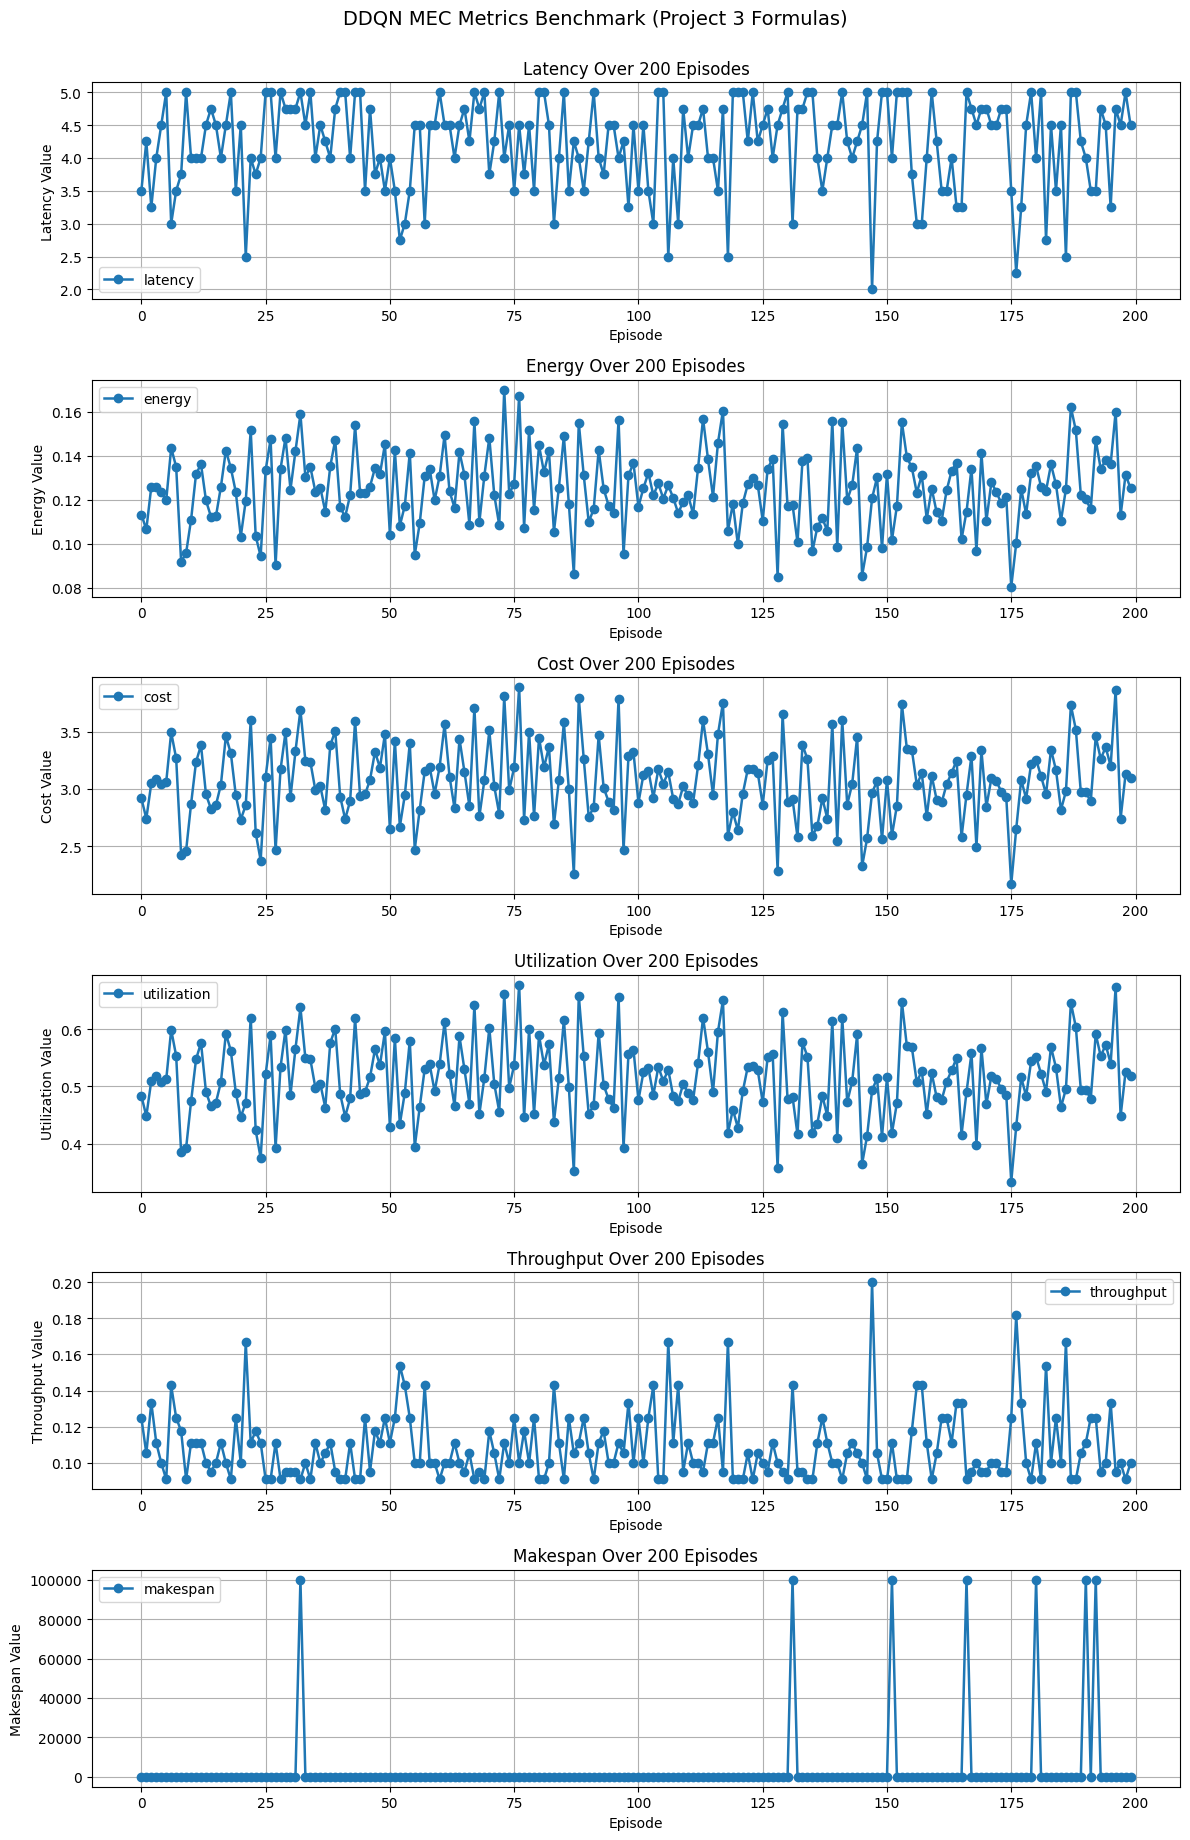

In [38]:
# 📌 Cell 9: Plotting Results (Each Metric in Separate Subplot)

import matplotlib.pyplot as plt

# --- Sample every 20 points (to get 200 episode averages) ---
sample_interval = 20
metrics_sampled = metrics_df.iloc[::sample_interval, :].reset_index(drop=True)

# --- Plot settings ---
metric_names = list(metrics_sampled.columns)
num_metrics = len(metric_names)

plt.figure(figsize=(12, 3 * num_metrics))  # Adjust height based on number of metrics

for i, k in enumerate(metric_names, 1):
    plt.subplot(num_metrics, 1, i)
    plt.plot(metrics_sampled[k], label=k, linewidth=1.8, marker='o')
    plt.legend()
    plt.title(f"{k.capitalize()} Over 200 Episodes")
    plt.xlabel("Episode")
    plt.ylabel(f"{k.capitalize()} Value")
    plt.grid(True)

plt.tight_layout()
plt.suptitle("DDQN MEC Metrics Benchmark (Project 3 Formulas)", fontsize=14, y=1.02)
plt.show()


In [ ]:
# Test Summary
print(metrics_summary)
df = pd.DataFrame(metrics_df)

# Summary statistics
summary = df.mean().to_frame("Mean")
summary["StdDev"] = df.std()
# print(summary)
summary.loc["reward"] = [mean_reward, std_reward]
print("📊 Performance Summary (DDQN):")
display(summary.round(4))
# summary_df = pd.DataFrame.from_dict({'Hybrid_Model_summary': summary})
summary.to_csv('hybrid_model_summary.csv')
print("\nTest summary saved to hybrid_model_summary.csv")

In [ ]:
# End of notebook

In [ ]:
# Comparison between Hybrid Model and Base Model Plotting Code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Extraction and Structuring (Same as before) ---

# Data extracted from the SECOND image (WhatsApp Image 2025-11-02 at 17.12.35)
# This data is now labeled as 'hybrid model'
data_hybrid_model = {
    'latency': {'mean': 4.1969, 'std': 0.7252},
    'energy': {'mean': 0.1251, 'std': 0.0158},
    'cost': {'mean': 3.0619, 'std': 0.3097},
    'utilization': {'mean': 0.5124, 'std': 0.0619},
    'throughput': {'mean': 0.1099, 'std': 0.0234},
    'makespan': {'mean': 2426.0165, 'std': 15.2024},
    'reward': {'mean': 50.6849, 'std': 0.4205}
}

# Data extracted from the FIRST image (WhatsApp Image 2025-11-02 at 17.03.34 - originally DDQN)
# This data is now labeled as 'Base model'
data_base_model = {
    'reward': {'mean': 0.2106, 'std': 0.0046},
    'makespan': {'mean': 2620.9277, 'std': 2172.3600},
    'energy': {'mean': 3.7486, 'std': 0.0460},
    'cost': {'mean': 52.5277, 'std': 0.0307},
    'latency': {'mean': 4.4544, 'std': 0.0626},
    'utilization': {'mean': 0.5055, 'std': 0.0061},
    'throughput': {'mean': 0.1018, 'std': 0.0015}
}

metrics_list = list(data_hybrid_model.keys()) 
all_metrics_data = []

for metric in metrics_list:
    mean_hybrid = data_hybrid_model[metric]['mean']
    std_hybrid = data_hybrid_model[metric]['std']
    
    mean_base = data_base_model.get(metric, {'mean': np.nan, 'std': np.nan})['mean']
    std_base = data_base_model.get(metric, {'mean': np.nan, 'std': np.nan})['std']

    all_metrics_data.append({
        'Metric': metric,
        'Hybrid_Mean': mean_hybrid,
        'Hybrid_Std': std_hybrid,
        'Base_Mean': mean_base,
        'Base_Std': std_base
    })

df = pd.DataFrame(all_metrics_data)
metric_order = ['latency', 'makespan', 'cost', 'energy', 'reward', 'utilization', 'throughput']
df['Metric'] = pd.Categorical(df['Metric'], categories=metric_order, ordered=True)
df = df.sort_values('Metric').set_index('Metric')


# --- 2. Plotting Functionality ---

def plot_comparison_improved(df):
    """Generates an improved figure with a separate subplot for each metric comparison."""
    
    # We will create 7 subplots in a single column
    fig, axes = plt.subplots(
        nrows=len(df), 
        ncols=1, 
        figsize=(12, 4 * len(df)), # Increased figure size for better spacing
        sharex=False # Still don't share x-axis, as each is a distinct comparison
    )
    
    bar_width = 0.30 # Slightly reduced bar width for better separation
    
    fig.suptitle('Performance Comparison: Hybrid Model vs. Base Model', 
                 fontsize=18, fontweight='bold', y=0.99) # Adjusted title position
    
    # Define colors for the algorithms
    color_hybrid = '#1f77b4'  # Blue
    color_base = '#ff7f0e' # Orange

    for i, metric in enumerate(df.index):
        ax = axes[i]
        
        # Get data for the current metric
        mean_hybrid = df.loc[metric, 'Hybrid_Mean']
        std_hybrid = df.loc[metric, 'Hybrid_Std']
        mean_base = df.loc[metric, 'Base_Mean']
        std_base = df.loc[metric, 'Base_Std']

        # X positions for the bars
        x_hybrid = 0
        x_base = bar_width + 0.05 # Slightly more spacing between bars

        # Grouped Bar Plot (Hybrid model first)
        rects_hybrid = ax.bar(
            x_hybrid, mean_hybrid, bar_width, 
            yerr=std_hybrid, capsize=7, # Increased capsize for visibility
            label='hybrid model', color=color_hybrid, edgecolor='black', linewidth=0.7
        )
        
        # Base model second
        rects_base = ax.bar(
            x_base, mean_base, bar_width, 
            yerr=std_base, capsize=7, 
            label='Base model', color=color_base, edgecolor='black', linewidth=0.7
        )

        # Labels and Title
        ax.set_ylabel(metric.capitalize(), fontsize=13, fontweight='semibold')
        ax.set_title(f'{metric.capitalize()} Comparison', fontsize=15, pad=10, loc='left') # Title aligned left
        
        # Set x-axis ticks and labels clearly
        ax.set_xticks([x_hybrid, x_base])
        ax.set_xticklabels(['hybrid model', 'Base model'], fontsize=12, rotation=0) # No rotation needed with better spacing
        
        # Add a more prominent horizontal grid
        ax.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
        ax.set_axisbelow(True) # Ensure grid is behind the bars

        # Set y-axis to start from 0, or adjust for very small values
        if metric in ['energy', 'throughput', 'utilization', 'reward', 'cost', 'latency', 'makespan']:
            ax.set_ylim(bottom=0)
            
        # For 'makespan', if std is too large, cap the error bar visual for clarity
        if metric == 'makespan' and std_hybrid > mean_hybrid * 2: # Heuristic for very large std
             ax.errorbar(x_hybrid, mean_hybrid, yerr=min(std_hybrid, mean_hybrid), 
                         fmt='none', capsize=7, color='black') # Cap error bar visually
             ax.text(x_hybrid, mean_hybrid + min(std_hybrid, mean_hybrid) + (ax.get_ylim()[1]*0.05), # Position text above capped bar
                     f'Std: {std_hybrid:,.0f}', ha='center', va='bottom', fontsize=9, color='red')
        
        # Function to label the bars with their exact mean values
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                # Determine vertical offset based on the scale of the plot
                v_offset = ax.get_ylim()[1] * 0.03 if ax.get_ylim()[1] > 1 else ax.get_ylim()[1] * 0.1
                ax.annotate(
                    f'{height:,.4g}', # Use general format for better display of large/small numbers
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, fontweight='bold', color='black'
                )
                
        autolabel(rects_hybrid)
        autolabel(rects_base)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add a single legend at the bottom of the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, 
               bbox_to_anchor=(0.5, 0.01), fontsize=12, frameon=False)

    # Adjust layout to prevent overlap and make space for the title and legend
    plt.tight_layout(rect=[0, 0.05, 1, 0.96]) # Adjusted rect to give more space
    plt.show()

# --- 3. Run Plotting ---
plot_comparison_improved(df)
